In [1]:
cd ..

C:\Users\johan\github\designresolver


In [2]:
from testgraph import Ein, Eout, Rin
from graphutils import draw_graph_graphical_props, flat_graph_formulation

# Typed Graph (Flat Formulation graph)

This is a graph where each node is assigned the type of variable, component or solver

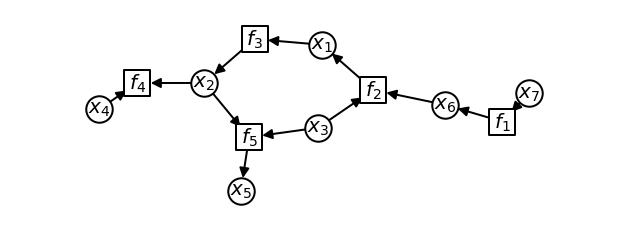

In [3]:
G = flat_graph_formulation(Ein, Eout, Rin)
draw_graph_graphical_props(G, prog='sfdp', figsize=(11,4))

# From random example

In [16]:
from testproblems import generate_random_prob
from collections import OrderedDict
from operators import sort_scc, reorder_merge_solve
from nestedgraph import build_typedgraph
from workflow import generate_workflow
from graphutils import merge_edges

In [5]:
n_eqs = 4
n_vars = 8
seed = 42#8 is triang#seed 10 is nice
sparsity = .8#1.1 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
Ein = {key: tuple(vr-n_eqs for vr in var if vr !=dout[key]) for key,var in eqv.items()}
Eout = {key: (var-n_eqs,) for key,var in dout.items()}
Rin = dict()
Ftree=OrderedDict((idx,1) for idx in range(n_eqs))
Stree=dict()
Vtree=dict()
edges = Ein, Eout, Rin
tree = Ftree, Stree, Vtree

In [6]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)

In [7]:
merge_order

[{f_2}, {f_0, f_3}, {f_1}]

In [8]:
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [9]:
ntree

(OrderedDict([(2, 1), (0, 2), (3, 2), (1, 1)]), {2: 1}, {1: 2, 3: 2})

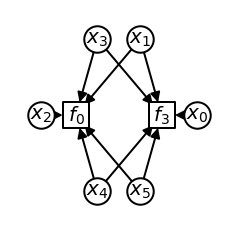

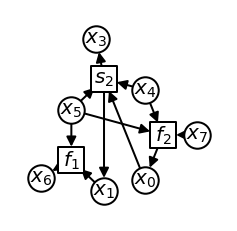

In [10]:
graphs = build_typedgraph(nedges, ntree)
for key,graph in graphs.items():
    draw_graph_graphical_props(graph, {}, prog='circo', figsize=(4,4))

## Workflow resolve

In [13]:
nedges

({0: (2, 3, 4, 5), 1: (1, 5), 2: (4, 5, 7), 3: (0, 1, 4, 5)},
 {3: (None,), 1: (6,), 2: (0,), 0: (None,)},
 {0: (1,), 3: (3,)})

In [56]:
workflow = generate_workflow(nedges, ntree)

In [67]:
workflow

[('solver', 1, None, set(), set()),
 ('exec', 2, 1),
 ('solver', 2, 1, {1, 3}, {0, 3}),
 ('exec', 1, 1)]

In [97]:
def solver_workflow(a,b,c,d):
    return [(fset[computation_map[elt]][0], f[fset[computation_map[elt]]]) for elt in d], c 
def exec_workflow(a,b):
    edges = nedges
    Ein = merge_edges(edges[0], edges[2])
    Eout = edges[1]
    return (Ein[a], f[fset[computation_map[a]]], Eout[a])

In [98]:
[(solver_workflow(*elt[1:]) if elt[0] == 'solver' else exec_workflow(*elt[1:])) for elt in workflow]

[([], set()),
 ((4, 5, 7), 'eq2', (0,)),
 ([((1, 2, 3, 4, 5), 'eq0'), ((0, 1, 3, 4, 5), 'eq3')], {1, 3}),
 ((1, 5), 'eq1', (6,))]

In [35]:
comp = 0

In [70]:
f = {
    ((1,2,3,4,5),0,(None,)): 'eq0',
    ((0,1,3,4,5),3,(None,)): 'eq3',
    ((1,5,),1,(6,)): 'eq1',
    ((4,5,7),2,(0,)): 'eq2',
}

In [71]:
fset = {(frozenset(ins),comp,frozenset(outs)): (ins,comp,outs) for ins,comp,outs in f.keys()}

In [72]:
def get_computation_map(edges):
    Ein = merge_edges(edges[0], edges[2])
    Eout = edges[1]
    computation_map = dict()
    for comp, ins in Ein.items():
        key = (frozenset(ins),comp,frozenset(Eout[comp]))
        computation_map[comp] = key
    return computation_map

In [73]:
computation_map = get_computation_map(nedges)

In [74]:
fset[computation_map[0]]

((1, 2, 3, 4, 5), 0, (None,))

In [18]:
Ein = merge_edges(nedges[0], nedges[2])

In [37]:
key = frozenset(Ein[comp]),comp,frozenset(nedges[1][comp])

In [32]:
fset = {(frozenset(ins),comp,frozenset(outs)): (ins,comp,outs) for ins,comp,outs in f.keys()}

In [40]:
fset[key]

((1, 2, 3, 4, 5), 0, (None,))